In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import shap
from scipy.stats import uniform, randint

data = pd.read_csv('data/EPC_Catalonia.csv')

/Users/marc/.pyenv/versions/3.11.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_86755/3023433341.py:13: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/EPC_Catalonia.csv')


In [8]:
# Load data
df = data.copy()
# Define target variable (Energy Consumption)
target = "Consum d'energia final"

# Extract date features
df["DATA_ENTRADA"] = pd.to_datetime(df["DATA_ENTRADA"], errors="coerce")
df["YEAR"] = df["DATA_ENTRADA"].dt.year
df["MONTH"] = df["DATA_ENTRADA"].dt.month

# Drop original date column
df.drop(columns=["DATA_ENTRADA"], inplace=True)

# Numerical features
numeric_features = [
    "METRES_CADASTRE", "ANY_CONSTRUCCIO", "Energia primària no renovable", "Emissions de CO2",
    "Energia calefacció", "Energia refrigeració", "Energia ACS", "Energia enllumenament",
    "Energia calefacció demanda", "Energia refrigeració demanda", "VALOR AILLAMENTS",
    "VALOR FINESTRES", "YEAR", "MONTH", "Cost anual aproximat d'energia per habitatge"
]

# Categorical features (to encode)
categorical_features = [
    "POBLACIO", "COMARCA", "NOM_PROVINCIA", "CODI_POBLACIO", "CODI_COMARCA", "CODI_PROVINCIA",
    "ZONA CLIMATICA", "US_EDIFICI", "VEHICLE ELECTRIC", "SOLAR TERMICA", "SOLAR FOTOVOLTAICA",
    "SISTEMA BIOMASSA", "XARXA DISTRICTE", "ENERGIA GEOTERMICA", "REHABILITACIO_ENERGETICA",
    "Qualificació de consum d'energia primaria no renovable", "Qualificacio d'emissions de CO2"
]

# Convert binary categorical features to numeric (Yes/No -> 1/0)
binary_features = ["VEHICLE ELECTRIC", "SOLAR TERMICA", "SOLAR FOTOVOLTAICA", 
                   "SISTEMA BIOMASSA", "XARXA DISTRICTE", "ENERGIA GEOTERMICA", 
                   "REHABILITACIO_ENERGETICA"]

for col in binary_features:
    df[col] = df[col].str.lower().map({'si': 1, 'no': 0})        


/var/folders/xz/5bn1vdj146n6586g9r465k_40000gn/T/ipykernel_67147/4117161107.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DATA_ENTRADA"] = pd.to_datetime(df["DATA_ENTRADA"], errors="coerce")


In [9]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert to string to handle NaNs
    label_encoders[col] = le  # Store encoder for future use
    

# Drop NaN values
df = df[numeric_features + categorical_features + [target]].dropna()


In [10]:
# Split data into train/test
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Standardize numerical features
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# ---- Linear Regression Model ----
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Metrics for Linear Regression
print("\nLinear Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.2f}")


Linear Regression Metrics:
MAE: 36.67
RMSE: 114.52
R² Score: 0.22


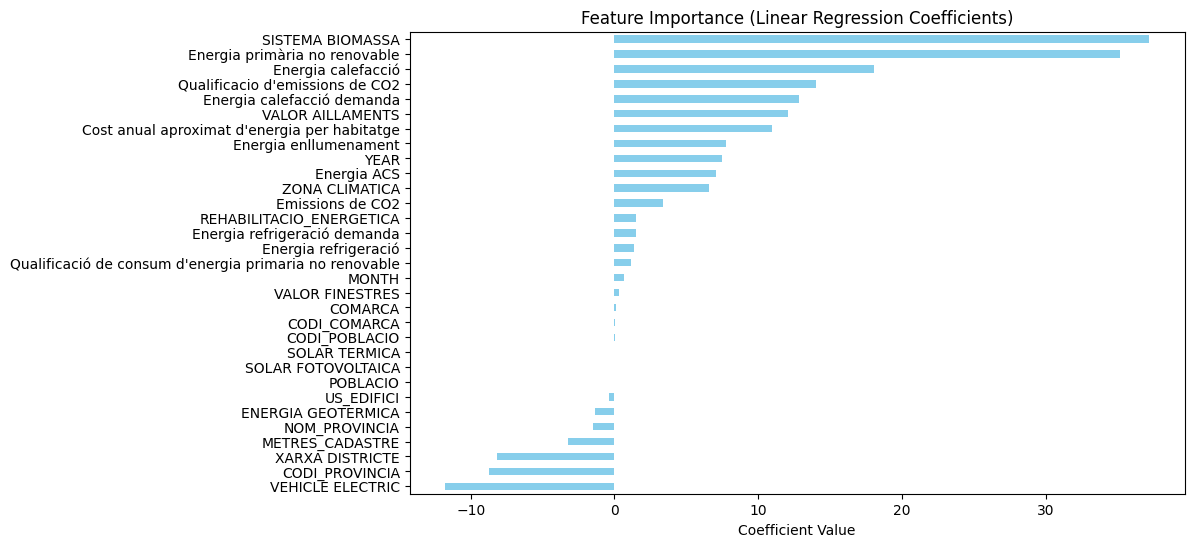

In [20]:
# ---- Feature Importance for Polynomial Regression ----
plt.figure(figsize=(10, 6))
coefficients = pd.Series(lr_model.coef_, index=lr_model.feature_names_in_)
coefficients.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()

In [15]:
params = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
# Train final XGB model with best parameters
xgb_best = XGBRegressor(**params, random_state=42)
xgb_best.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_best.predict(X_test)

# Metrics for XGBRegressor
print("\nOptimized XGBRegressor Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")



Optimized XGBRegressor Metrics:
MAE: 35.91
RMSE: 88.57
R² Score: 0.6068


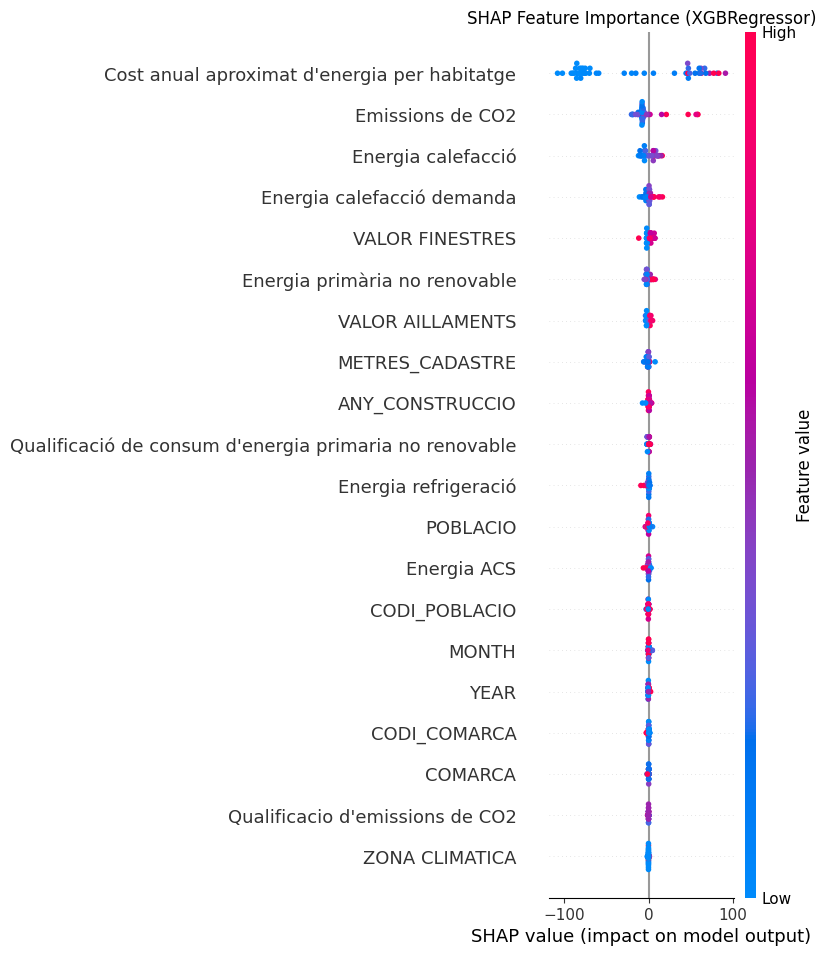

In [16]:
# ---- Feature Importance with SHAP for XGB ----
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test)

# Plot SHAP Summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance (XGBRegressor)")
plt.show()



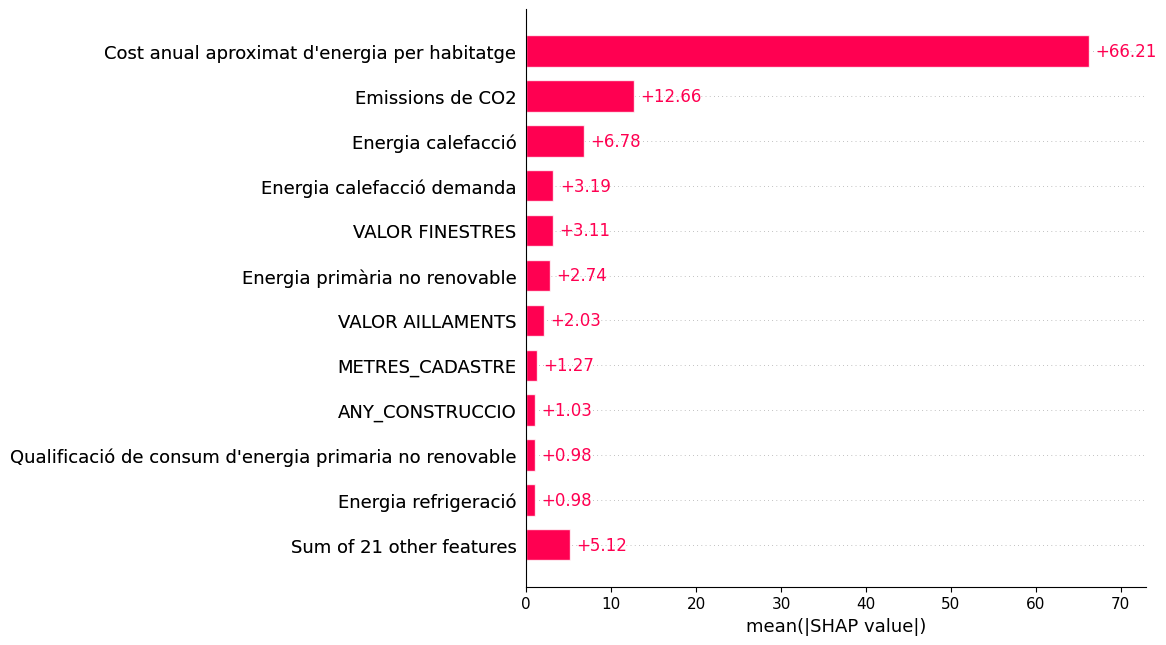

In [18]:
shap.plots.bar(shap_values, max_display=12)

In [36]:
df = data.copy()

selected_cols = [
    "METRES_CADASTRE", "Energia primària no renovable", "Emissions de CO2",
    "Energia calefacció", "Energia refrigeració", "Energia calefacció demanda", "VALOR AILLAMENTS",
    "Cost anual aproximat d'energia per habitatge", "VALOR FINESTRES",
    "POBLACIO",  "Qualificació de consum d'energia primaria no renovable",
    "VEHICLE ELECTRIC", "SISTEMA BIOMASSA", "REHABILITACIO_ENERGETICA", 
    "Consum d'energia final"
    ]

df = df[selected_cols].dropna()

# Numerical features
numeric_features = [
    "METRES_CADASTRE", "Energia primària no renovable", "Emissions de CO2",
    "Energia calefacció", "Energia refrigeració", "Energia calefacció demanda", "VALOR AILLAMENTS",
    "Cost anual aproximat d'energia per habitatge", "VALOR FINESTRES"
]

# Categorical features (to encode)
categorical_features = [
    "POBLACIO",  "Qualificació de consum d'energia primaria no renovable",
    "VEHICLE ELECTRIC", "SISTEMA BIOMASSA", "REHABILITACIO_ENERGETICA"]

# Convert binary categorical features to numeric (Yes/No -> 1/0)
binary_features = ["VEHICLE ELECTRIC", 
                   "SISTEMA BIOMASSA",  
                   "REHABILITACIO_ENERGETICA"]

for col in binary_features:
    df[col] = df[col].str.lower().map({'si': 1, 'no': 0})      



In [21]:
# Split data into train/test
target = "Consum d'energia final"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# ---- Linear Regression Model ----
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Metrics for Linear Regression
print("\nLinear Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_lr):.2f}")


Linear Regression Metrics:
MAE: 19.09
RMSE: 83.44
R² Score: 0.50


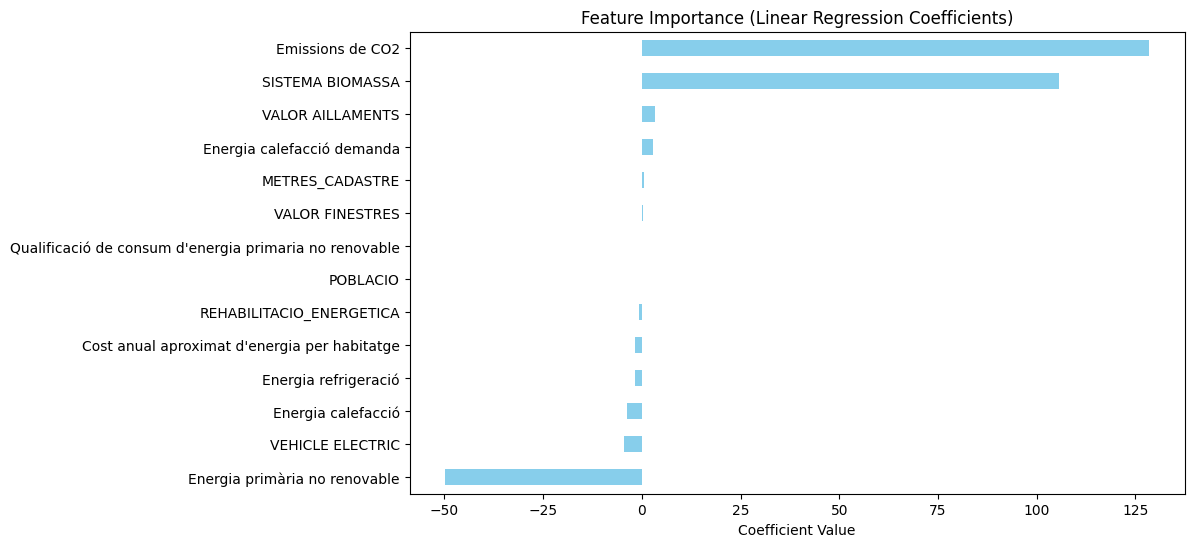

In [5]:
# ---- Feature Importance for Polynomial Regression ----
plt.figure(figsize=(10, 6))
coefficients = pd.Series(lr_model.coef_, index=lr_model.feature_names_in_)
coefficients.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.show()

In [6]:
xgb = XGBRegressor(random_state=42)

# Best parameters
params = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
# Train final XGB model with best parameters
xgb_best = XGBRegressor(**params, random_state=42)
xgb_best.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_best.predict(X_test)

# Metrics for XGBRegressor
print("\nOptimized XGBRegressor Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_xgb):.4f}")



Optimized XGBRegressor Metrics:
MAE: 5.15
RMSE: 65.60
R² Score: 0.6933


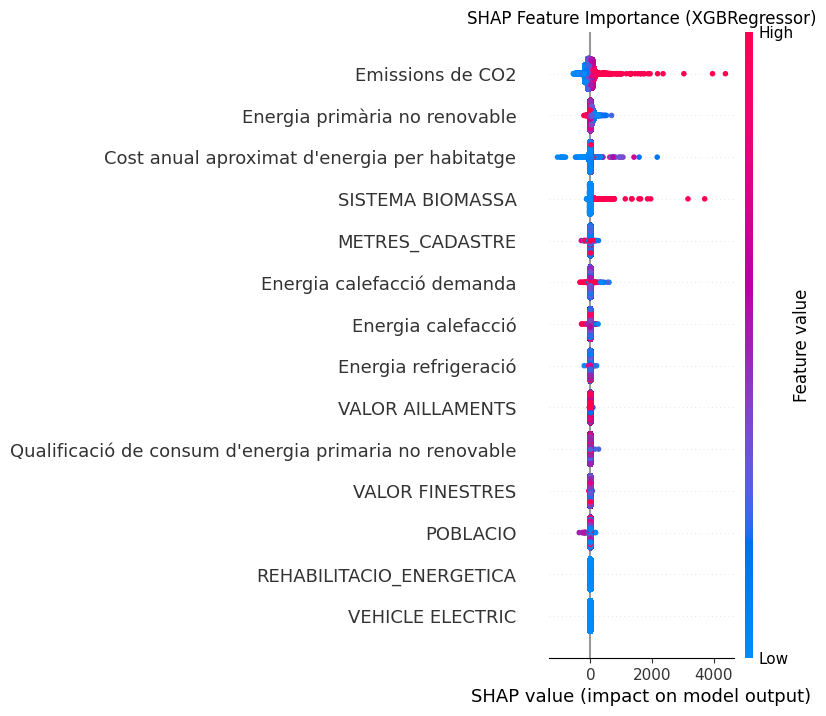

In [9]:
# ---- Feature Importance with SHAP for XGB ----
#explainer = shap.Explainer(xgb_best)
#shap_values = explainer(X_test)

# Plot SHAP Summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance (XGBRegressor)")
plt.show()



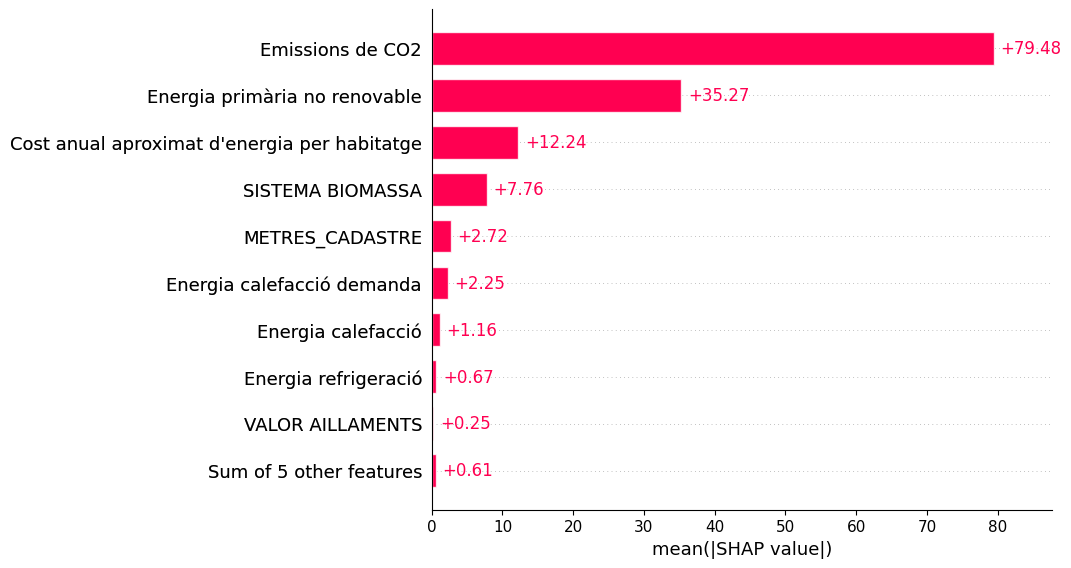

In [38]:

shap.plots.bar(shap_values, max_display=10)

In [24]:
import pickle
import torch

# Define filenames
filepaths = {
    "encoders": "models/label_encoders.pkl",
    "scaler": "models/scaler.pkl",
    "linear_regression": "models/linear_model.pkl",
    "xgb_model": "models/xgb_model.pkl",
    "data": "models/dataframe.pkl"
}

# ---- Save Dictionary ----
with open(filepaths["encoders"], "wb") as f:
    pickle.dump(label_encoders, f)

with open(filepaths["scaler"], "wb") as f:
    pickle.dump(scaler, f)

# ---- Save Linear Regression Model ----
with open(filepaths["linear_regression"], "wb") as f:
    pickle.dump(lr_model, f)

# ---- Save XGBoost Model ----
with open(filepaths["xgb_model"], "wb") as f:
    pickle.dump(xgb_best, f)

# ---- Save DataFrame ----
with open(filepaths["data"], "wb") as f:
    pickle.dump(df, f)

print("\n✅ All objects saved successfully!")



✅ All objects saved successfully!
